In [432]:
%matplotlib widget
import roslib
import rosbag
import rospy
import cv2
import math
import datetime
import numpy as np
import ros_numpy
import os
from sensor_msgs.msg import PointCloud2, PointField, Image
from datetime import *
from cv_bridge import CvBridge
from cv_bridge import CvBridgeError
import plotly
import plotly.graph_objs as go
from matplotlib import pyplot as plt
plotly.offline.init_notebook_mode()

In [433]:
from operator import truediv
from xml.etree.ElementInclude import LimitedRecursiveIncludeError


rosbag_path = '/home/user/catkin_ws/yolov5/data/rosbag/'
rosbag_file = os.path.join(rosbag_path, '2022-10-21-13-59-30.bag')

image_path = os.path.join(rosbag_path, 'images')
image_Time_Stamps_File_path = os.path.join(image_path, 'timestamps.txt')
pointcloud_path =  os.path.join(rosbag_path, 'velodyne_points')
pointcloud_Time_Stamps_File_path = os.path.join(pointcloud_path, 'timestamps.txt')

image_topic_name = '/hikrobot_camera/image_raw'
pointcloud_topic_name = '/velodyne_points'


def ImageCreator():
    bridge = CvBridge()
    timeStampsFile = open(image_Time_Stamps_File_path, 'w')
    with rosbag.Bag(rosbag_file, 'r') as bag:
        num = 0
        for topic, msg, t in bag.read_messages():
            if topic == image_topic_name:
                try:
                    cv_image = bridge.imgmsg_to_cv2(msg, "bgr8")
                except CvBridgeError as e:
                    print(e)

                pointcloud_name = "%d" % num + ".png"
                cv2.imwrite(os.path.join(image_path, pointcloud_name), cv_image)

                timeStr = "%.9f" % msg.header.stamp.to_sec()
                dateTimeStr = int(timeStr[0:10])
                dotTimeStr = timeStr[11:]

                localTime = datetime.fromtimestamp(dateTimeStr)
                localTimeStr = str(localTime)
                timeStamps = localTimeStr + '.' + dotTimeStr

                timeStampsFile.write(timeStamps)
                timeStampsFile.write('\n')
                num += 1


def PointcloudCreator():
    timeStampsFile = open(pointcloud_Time_Stamps_File_path, 'w')
    with rosbag.Bag(rosbag_file, 'r') as bag:
        num = 0
        for topic, msg, t in bag.read_messages():
            if topic == pointcloud_topic_name:
                PointCloud = msg.data
                pointcloud_name = "%d" % num
                PointCloudFile = open(os.path.join(pointcloud_path, pointcloud_name), 'wb')

                xyz_array = ros_numpy.point_cloud2.pointcloud2_to_xyz_array(msg)
                val = np.save(PointCloudFile, xyz_array)
                PointCloudFile.close()

                timeStr = "%.9f" % msg.header.stamp.to_sec()
                dateTimeStr = int(timeStr[0:10])
                dotTimeStr = timeStr[11:]

                localTimeStr = datetime.fromtimestamp(dateTimeStr)
                localTimeStr = str(localTimeStr)
                timeStamps = localTimeStr + '.' + dotTimeStr

                timeStampsFile.write(timeStamps)
                timeStampsFile.write('\n')
                num += 1


def parse_datetime(line,fmt):                #this really important function is used to parse timestamp with date from a string
    try:
        t = datetime.strptime(line, fmt)
    except ValueError as v:
        if len(v.args) > 0 and v.args[0].startswith('unconverted data remains: '):
            line = line[:-(len(v.args[0]) - 26)]
            t = datetime.strptime(line, fmt)
        else:
            raise
    return t

def is_taken(array, index):
    for match in array:
        if match[0] == index:
            return True
    return False
    

def eval_timestamps():
    fmt="%Y-%m-%d %H:%M:%S.%f"
    cam_stamps = open(os.path.join(image_path, 'timestamps.txt'), 'r')
    ldr_stamps = open(os.path.join(pointcloud_path, 'timestamps.txt'), 'r')

    cam_times = []
    ldr_times = []

    for line in cam_stamps:     
        cam_times.append(parse_datetime(line,fmt))  

    for line in ldr_stamps:
        ldr_times.append(parse_datetime(line,fmt))   

    #find the best matching timestamp solution
    diffs = [0.0,0.0,0.0]
    limit = len(cam_times)
    if limit/10 > 10:
        limit = round(limit/10)
    for n1 in range(limit):
        for n2 in range(-1, 2):
            try:
                index = n1 + n2
                diff=abs(cam_times[n1]-ldr_times[index]).total_seconds()
                if n2 == -1:
                    diffs[0] = diffs[0]+diff
                if n2 == 0:
                    diffs[1] = diffs[1]+diff
                if n2 == 1:
                    diffs[2] = diffs[2]+diff
            except IndexError:
                pass
    #find starting index in case of desync
    offset = 0
    smallest = np.min(np.array(diffs))
    for n in range(len(diffs)):
        if diffs[n] == smallest:
            offset = n-1
    return [offset, len(cam_times)]




In [434]:
#image_creator = ImageCreator()

In [435]:
#pc_creator = PointcloudCreator()

In [436]:
idx_len = eval_timestamps()

In [437]:
def visualise(points):
    xs = points[:, 0].tolist()
    ys = points[:, 1].tolist()
    zs = points[:, 2].tolist()
    trace = go.Scatter3d(
        x=xs,  # <-- Put your data instead
        y=ys,  # <-- Put your data instead
        z=zs,  # <-- Put your data instead
        mode='markers',
        marker={
            'size': 1,
            'opacity': 0.8,
        }
    )
    # Configure the layout.
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    data = [trace]
    plot_figure = go.Figure(data=data, layout=layout)
    plot_figure.update_layout(scene_aspectmode='data')
    plotly.offline.iplot(plot_figure)

def ypr2mat(pyr): #yaw pitch roll, z y x
    a = pyr[0]  # yaw
    b = pyr[1]  # pitch
    y = pyr[2]  # roll
    #first row
    r00 = math.cos(a)*math.cos(b)
    r01 = math.cos(a)*math.sin(b)*math.sin(y)-math.sin(a)*math.cos(y)
    r02 = math.cos(a)*math.sin(b)*math.cos(y)+math.sin(a)*math.sin(y)
    #second row
    r10 = math.sin(a)*math.cos(b)
    r11 = math.sin(a)*math.sin(b)*math.sin(y)+math.cos(a)*math.cos(y)
    r12 = math.sin(a)*math.sin(b)*math.cos(y)-math.cos(a)*math.sin(y)
    #third row
    r20 = -math.sin(b)
    r21 = math.cos(b)*math.sin(y)
    r22 = math.cos(b)*math.cos(y)   

    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

def map_color(begin, end, value): #red close, blue far
    ratio = (value - begin) / (end - begin)
    if ratio > 1:
        ratio = 1
    if ratio < 0:
        ratio = 0
    r = int(255 - 255 * ratio)
    g = int(ratio * 255)
    b = int(ratio * 255)
    return (r, g, b)

def dist(vec):
    return math.sqrt(vec[2]**2)

def generate_permutations():
    perms = []
    perms.append(np.array([3.14159, -1.57079632679, -1.57079632679]))
    return perms
    for i in range(-3, 3):
        for k in range(-3, 3):
            perms.append(np.array([i*1.57079632679, -1.57079632679, k*1.57079632679]))
    return perms

YOLOv5 🚀 v6.2-209-g2a81c96 Python-3.9.7 torch-1.12.1+cu102 CPU


Setup complete ✅ (4 CPUs, 15.5 GB RAM, 97.3/116.3 GB disk)


Using cache found in /home/user/.cache/torch/hub/ultralytics_yolov5_master


[     3.1416     -1.5708     -1.5708]


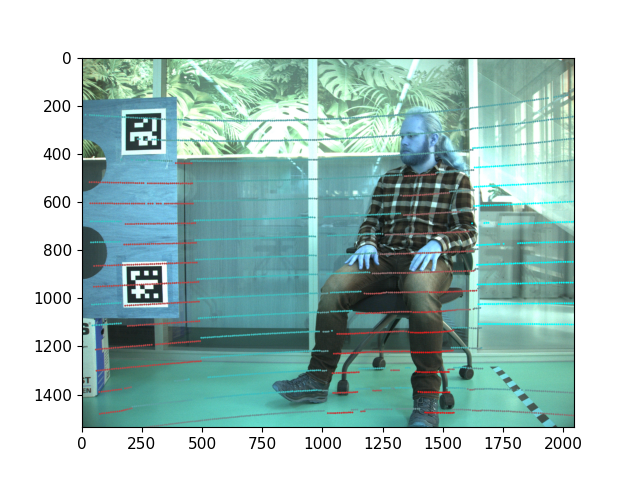

In [438]:
from xml.etree.ElementTree import PI
import torch
import utils

display = utils.notebook_init()
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', _verbose=False)  # yolov5n - yolov5x6 official model
model.classes = [0]

#all these matrices come from the calibration results obtained
cam_mat = np.array([
    [2299.303861, 0, 997.019631],
    [0, 2301.232046, 815.269991],
    [0, 0, 1]])
proj_mat = np.array([
    [2208.608154, 0, 992.949178, 0], 
    [0, 2244.101074, 821.213246, 0], 
    [0, 0, 1, 0]])
dist_cof = np.array([-0.217529, 0.169305, 0.005223999999999999, -0.001093, 0])
rot_ypr = np.array([0.0151055, -0.0502163, -0.0542069])
rot_test = np.array([3.14159, -1.57079632679, -1.57079632679]) #3.14159, -1.57079632679, -1.57079632679 wrong way around z y x
tvec = np.array([-0.0542069, -0.0502163, 0.0151055])  


min = 200
max = 201
for image in sorted(os.listdir(image_path)):
    # check if the image ends with png
    if image.endswith(".png") and max > 0:
        index = int(os.path.splitext(image)[0])
        if index < min or index > max:
            continue
        perms = generate_permutations()
        for perm in perms:
            rot_test = perm
            print(rot_test)
            results = model(os.path.join(image_path, image))
            points = np.load(os.path.join(pointcloud_path, str(index+idx_len[0])))
            tf_points = np.zeros((points.shape[0], 3))

            #actual projection with function
            #(rvec, jacob) = cv2.Rodrigues(ypr2mat(rot_ypr))
            #tf_points, _ = cv2.projectPoints(points, rvec, tvec, cam_mat, None)


            #diy projection to understand what im doing
            
            #for n in range(len(points)):
            #    tf_mat = ypr2mat(rot_test) 
            #    tf_points[n] = np.matmul(np.matmul(cam_mat, ), points[n])
            #visualise(rotated_points)
            #zeros = np.zeros((len(imagePoints), 1))
            #visualise(np.hstack((imagePoints.squeeze(), zeros)))

            #3d visualisation


            rotated_points = np.zeros((points.shape[0], 3))
            translated_points = np.zeros((points.shape[0], 3))
            for n in range(len(points)):
                rotated_points[n] = np.matmul(ypr2mat(rot_test + rot_ypr), points[n])
                translated_points[n] =  rotated_points + tvec
                tf_points[n] = np.matmul(proj_mat, np.append(rotated_points[n], 1.0))
                

            img = cv2.imread(os.path.join(image_path, image),5)
            u_img = cv2.undistort(img, cam_mat, dist_cof, None, cam_mat)
            for point in tf_points:
                p = point.squeeze()
                img = cv2.circle(img, (int(p[0]/p[2]), int(p[1]/p[2])), 4, map_color(2, 4, dist(p)), thickness=-1)

            plt.figure()
            plt.imshow(img)
            plt.draw()
            plt.show()
            visualise(rotated_points)
            visualise(tf_points)
            #2048 1536

            #for rows in results.pandas().xyxy[0]:
            #for i in range(len(results.pandas().xyxy[0])):
            #    row = results.pandas().xyxy[0].iloc[i]
            #    print(row)
            #    x = row['xmin']
            #    y = row['ymin']
            #    w = row['xmax'] - x
            #    h = row['ymax'] - y

        max-=1
